In [13]:
# Module import
from IPython.display import Image
import sys
import pandas as pd

# To use interact -- IPython widget
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


# append to path the folder that contains the analytic scanner
sys.path.append('../GaiaLab/scan/analytic_scanner')
# local imports
#from gaia_analytic_toymodel import *

from scipy import interpolate
import timeit

import frame_transformations as ft
from scanner import Scanner
from satellite import Satellite
from source import Source

import constants as const

from quaternion import Quaternion
from agis import Agis
from agis import Calc_source
from agis_functions import *

from analytic_plots import *

# Ipython magics
%load_ext autoreload
%autoreload 2
# %matplotlib notebook 
# %matplotlib widget
# %matplotlib ipympl

# Set some user-specific variables
# MAIN_FOLDER = '../' # relative path to project folder
# FIG_FOLDER = 'figures/' # relative path to figure

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# **Some functions:**

In [60]:
def compare_attitudes(gaia, Solver, my_times):
    fig = plt.figure()
    colors = ['red', 'orange', 'blue', 'green']
    labels_gaia = ["w", "x", "y", "z"]
    labels_solver = ["w_solv", "x_solv", "y_solv", "z_solv"]
    gaia_attitudes = [gaia.s_w(my_times), gaia.s_x(my_times), 
                      gaia.s_y(my_times), gaia.s_z(my_times)]
    solver_attitudes = []
    for i in range(4):
        plt.plot(my_times,gaia_attitudes[i], ':', color=colors[i], label=labels_gaia[i])
        plt.plot(my_times,Solver.attitude_splines[i](my_times), '--', color=colors[i], label=labels_solver[i])
    plt.xlabel("my_times [%s]"%len(my_times))
    plt.legend(loc=9, bbox_to_anchor=(1.1, 1))
    plt.title('Attitudes in time intervals')
    plt.show()

# **Initializing objects:**

In [14]:
# # create all the objects we will need:
# parameters for the notebook
t_init = 1/24/60
t_end = t_init + 1/24 # 365*5
my_dt = 1/24/20 # [days]

spline_degree = 3  # actually it is the spline degree
gaia = Satellite(ti=t_init, tf=t_end, dt= my_dt, k=spline_degree)
print('Sat created')
my_times = np.linspace(t_init, t_end, num=100, endpoint=False)
real_sources = []
calc_sources = []
for t in my_times:
    alpha, delta = generate_observation_wrt_attitude(gaia.func_attitude(t))
    real_src_tmp = Source(str(t),np.degrees(alpha), np.degrees(delta), 0, 0, 0, 0)
    calc_src_tmp = Calc_source('calc_'+str(t), [t], real_src_tmp.get_parameters()[0:5], real_src_tmp.get_parameters()[5])
    real_sources.append(real_src_tmp)
    calc_sources.append(calc_src_tmp)
print('Sources created!')

Sat created
Sources created!


len(real_sources):  100


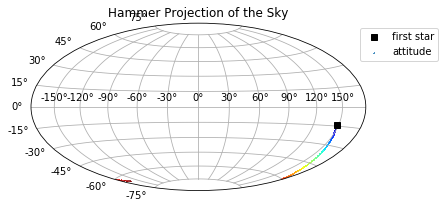

In [15]:
fig = plt.figure()
plt.subplot(111, projection="hammer")
alphas = []
deltas = []
#print('my_times: ', my_times)
print('len(real_sources): ', len(real_sources))
for i, s in enumerate(real_sources):
    alpha, delta = s.alpha-np.pi, s.delta
    #print(i, alpha, delta)
    alphas.append(alpha)
    deltas.append(delta)
    if i==0:
        plt.plot(alpha, delta, 'sk', label='first star')
    else:
        #plt.plot( alpha, delta,',')
        pass
plt.scatter(alphas, deltas, c=my_times, marker='+', s=(72./fig.dpi)**2, cmap='jet', alpha=0.8,
               label='attitude', lw=2)

plt.title("Hammer Projection of the Sky")
plt.legend(loc=9, bbox_to_anchor=(1.1, 1))
plt.grid(True)

In [16]:
# test if source and calc source are equal (as they should be)
np.testing.assert_array_almost_equal(np.array(real_sources[0].get_parameters()[0:5]), calc_sources[0].s_params)

In [17]:
# create Solver
Solver = Agis(gaia, calc_sources, real_sources, attitude_splines=[gaia.s_w, gaia.s_x, gaia.s_y, gaia.s_z], spline_degree=spline_degree,
             attitude_regularisation_factor=1e-2)

# **Visualisation:**

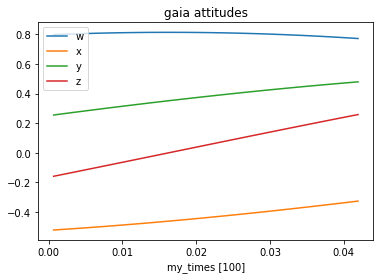

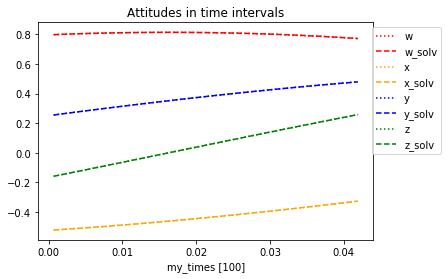

In [64]:
plt.plot(my_times,gaia.s_w(my_times),label="w")
plt.plot(my_times,gaia.s_x(my_times),label="x")
plt.plot(my_times,gaia.s_y(my_times),label="y")
plt.plot(my_times,gaia.s_z(my_times),label="z")
plt.xlabel("my_times [%s]"%len(my_times)), plt.title('gaia attitudes')
plt.legend()
plt.show()
compare_attitudes(gaia, Solver, my_times)

In [65]:
gaia.s_w.get_knots()

array([0.00208333, 0.00625   , 0.00833333, 0.01041667, 0.0125    ,
       0.01458333, 0.01666667, 0.01875   , 0.02083333, 0.02291667,
       0.025     , 0.02708333, 0.02916667, 0.03125   , 0.03333333,
       0.03541667, 0.0375    , 0.03958333, 0.04375   ])

# **Tests:**

## Test_0:
Test that the sources are aligned with the attitude

In [23]:
import astropy.units as u

eta,zeta = calculated_field_angles(calc_sources[0], gaia.func_attitude(my_times[0]), gaia, my_times[0])
print(np.array([eta,zeta])*u.rad.to(u.mas))
del u

[-4.57999874e-08 -9.44624740e-08]


OK

## Test_1:
Test the design and normal matrix:  
line 366 in agis.py should be checked:  dR_da_n = dR_da_i(dR_dq, self.att_bases[:, n_index, obs_time_index])  
some times are out of the knots range...

In [24]:
left_index = get_left_index(Solver.att_knots, my_times[0], M=Solver.M)

ValueError: t smaller than smallest knot

## Test_2:


21


Text(0.5, 1.0, '$|N_{aa}|$')

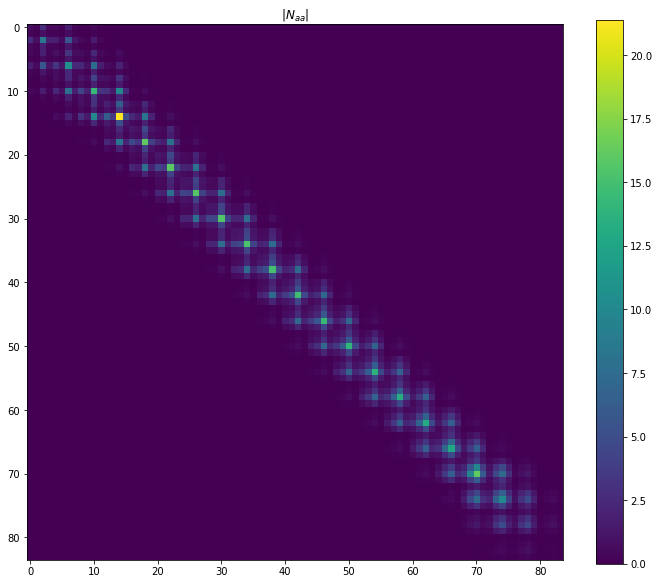

In [37]:
N_aa = Solver.compute_attitude_LHS()
plt.figure(figsize=(12,10))
plt.imshow(np.abs(N_aa), vmin=None, vmax=None)
plt.colorbar()
plt.title("$|N_{aa}|$")

(Text(0.5, 1.0, 'eigenvalues'), Text(0.5, 0, 'log scale'), None)

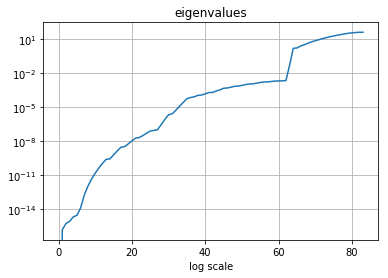

In [38]:
eig_vals, eig_vecs = np.linalg.eigh(N_aa)
plt.plot(eig_vals)
plt.yscale('log')
plt.title('eigenvalues'), plt.xlabel('log scale'), plt.grid()

## Extra tests:

In [10]:
# Ignore this cell if you don't want to modify the initial attitude
# Can be used to check that when recreating the splines in the solver we (almost) do not create additional errors
Solver.actualise_splines()
print('Error before Noise: ', Solver.error_function())
print('Errors after noise of attitude (not representatif):', error_between_func_attitudes(my_times, gaia.func_attitude, Solver.get_attitude))
c_noise = Solver.att_coeffs * np.random.rand(Solver.att_coeffs.shape[0], Solver.att_coeffs.shape[1]) * 1e-6
print('c_noise shape: ', c_noise.shape)
Solver.att_coeffs = Solver.att_coeffs + c_noise
Solver.actualise_splines()
#Solver.set_splines_basis()
print('Error after Noise: ', Solver.error_function())
print('Errors after noise of attitude (not representatif):', error_between_func_attitudes(my_times, gaia.func_attitude, Solver.get_attitude))

Error before Noise:  0.0
Errors after noise of attitude (not representatif): 0.0
c_noise shape:  (4, 21)
Error after Noise:  1.9760031280755065e-13
Errors after noise of attitude (not representatif): 2.685425275865405e-06


In [11]:
for i in range(0, 3):
    # np.testing.assert_array_equal(Solver.att_bases[i], Solver.att_bases[i+1])
    pass

### Taking a look at the splines:

In [12]:
gaia.s_w.get_knots()

array([0.00208333, 0.00625   , 0.00833333, 0.01041667, 0.0125    ,
       0.01458333, 0.01666667, 0.01875   , 0.02083333, 0.02291667,
       0.025     , 0.02708333, 0.02916667, 0.03125   , 0.03333333,
       0.03541667, 0.0375    , 0.03958333, 0.04375   ])

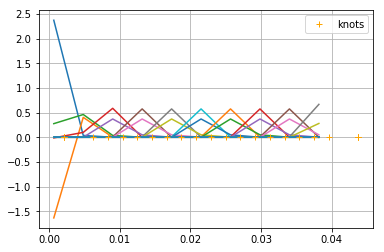

shape Solver.att_bases: (21, 10)
time ranging from:  0.0006944444444444444  to  0.03819444444444444
N= (4, 21)  || k= (25,)  || M= 4


In [66]:
basis = Solver.att_bases
f1 = plt.figure()
for b in basis:
    # plt.plot(range(len(my_times)), b)
    plt.plot(my_times, b)
plt.plot(Solver.att_knots, np.zeros(Solver.att_knots.shape), '+', color='orange', label='knots')
plt.grid(), plt.legend()
plt.show()

print('shape Solver.att_bases:', Solver.att_bases.shape)
print('time ranging from: ', my_times[0], ' to ', my_times[-1])
print('N=',Solver.att_coeffs.shape, ' || k=', Solver.att_knots.shape, ' || M=',Solver.M)

# **Taking a look to intermediate functions:**

**The N_aa[n,m] block:**

In [32]:
# set index and initialize block
m_index, n_index = (11, 12)
Naa_mn = np.zeros((4, 4))

In [33]:
# WARNING: here we take the knots of w since they should be the same for the 4 components
observed_times_m = get_times_in_knot_interval(Solver.all_obs_times, Solver.att_knots, m_index, Solver.M)
observed_times_n = get_times_in_knot_interval(Solver.all_obs_times, Solver.att_knots, n_index, Solver.M)

observed_times_mn = np.sort(helpers.get_lists_intersection(observed_times_m, observed_times_n))

print('knot m:', Solver.att_knots[m_index], 'knot m+M:', Solver.att_knots[m_index+Solver.M])
print('observed_times_mn:', observed_times_m)
print('knot n:', Solver.att_knots[n_index], 'knot n+M:', Solver.att_knots[n_index+Solver.M])
print('observed_times_mn:', observed_times_n)

print('\nobserved_times_mn:', observed_times_mn)

knot m: 0.020833333333333332 knot m+M: 0.029166666666666664
observed_times_mn: [0.02111111 0.02152778 0.02194444 0.02236111 0.02277778 0.02319444
 0.02361111 0.02402778 0.02444444 0.02486111 0.02527778 0.02569444
 0.02611111 0.02652778 0.02694444 0.02736111 0.02777778 0.02819444
 0.02861111 0.02902778]
knot n: 0.022916666666666665 knot n+M: 0.031249999999999997
observed_times_mn: [0.02319444 0.02361111 0.02402778 0.02444444 0.02486111 0.02527778
 0.02569444 0.02611111 0.02652778 0.02694444 0.02736111 0.02777778
 0.02819444 0.02861111 0.02902778 0.02944444 0.02986111 0.03027778
 0.03069444 0.03111111]

observed_times_mn: [0.02319444 0.02361111 0.02402778 0.02444444 0.02486111 0.02527778
 0.02569444 0.02611111 0.02652778 0.02694444 0.02736111 0.02777778
 0.02819444 0.02861111 0.02902778]


In [34]:
# compute dDL_da block
dDL_da_mn = np.zeros((4, 4))
for i, t_L in enumerate(observed_times_mn):
    
    source_index = Solver.get_source_index(t_L)
    calc_source = Solver.calc_sources[source_index]
    attitude = Solver.get_attitude(t_L)
    left_index = get_left_index(Solver.att_knots, t_L, M=Solver.M)
    obs_time_index = list(Solver.all_obs_times).index(t_L)
    if i<3:
        print('***** iteration #', i ,' *****')
        print('t:',t_L,' // source_index:', source_index, ' // time_index:', obs_time_index, )
        print('time according to time_index:', Solver.all_obs_times[obs_time_index], ' // left_index',left_index)
        print('before_left_index: ',Solver.att_knots[left_index-1], 
              ' // knot left_index:',Solver.att_knots[left_index], 
              ' // knot after left_index:',Solver.att_knots[left_index+1])

    # Ccompute the original objective function part
    # # WARNING: Here we put the Across scan and the along scan together
    dR_dq = compute_dR_dq(calc_source, Solver.sat, attitude, t_L)
    dR_da_m = dR_da_i(dR_dq, Solver.att_bases[m_index, obs_time_index])
    dR_da_n = dR_da_i(dR_dq, Solver.att_bases[n_index, obs_time_index])
    
    dDL_da_mn += dR_da_n @ dR_da_m.T
dDL_da_mn

***** iteration # 0  *****
t: 0.023194444444444445  // source_index: 54  // time_index: 54
time according to time_index: 0.023194444444444445  // left_index 12
before_left_index:  0.020833333333333332  // knot left_index: 0.022916666666666665  // knot after left_index: 0.024999999999999998
***** iteration # 1  *****
t: 0.02361111111111111  // source_index: 55  // time_index: 55
time according to time_index: 0.02361111111111111  // left_index 12
before_left_index:  0.020833333333333332  // knot left_index: 0.022916666666666665  // knot after left_index: 0.024999999999999998
***** iteration # 2  *****
t: 0.024027777777777776  // source_index: 56  // time_index: 56
time according to time_index: 0.024027777777777776  // left_index 12
before_left_index:  0.020833333333333332  // knot left_index: 0.022916666666666665  // knot after left_index: 0.024999999999999998


array([[ 0.44178855, -0.7308977 , -1.76688425,  0.56879458],
       [-0.7308977 ,  1.21101995,  2.92418813, -0.94180853],
       [-1.76688425,  2.92418813,  7.06705666, -2.27528505],
       [ 0.56879458, -0.94180853, -2.27528505,  0.73265683]])

In [29]:
# compute regularisation block
reg_block_mn = np.zeros((4, 4))
for i, t_L in enumerate(observed_times_mn):
    source_index = Solver.get_source_index(t_L)
    calc_source = Solver.calc_sources[source_index]
    attitude = Solver.get_attitude(t_L)
    left_index = get_left_index(Solver.att_knots, t_L, M=Solver.M)
    obs_time_index = list(Solver.all_obs_times).index(t_L)

    # Compute the regulation part
    coeff_basis_sum = compute_coeff_basis_sum(Solver.att_coeffs, Solver.att_bases,
                                              left_index, Solver.M, obs_time_index)
    # dDL_da_n = compute_DL_da_i(coeff_basis_sum, self.att_bases, obs_time_index, n_index)
    # dDL_da_m = compute_DL_da_i(coeff_basis_sum, self.att_bases, obs_time_index, m_index)
    dDL_da_n = compute_DL_da_i_from_attitude(attitude, Solver.att_bases, obs_time_index, n_index)
    dDL_da_m = compute_DL_da_i_from_attitude(attitude, Solver.att_bases, obs_time_index, m_index)
    reg_block_mn += Solver.attitude_regularisation_factor**2 * dDL_da_n @ dDL_da_m.T
reg_block_mn

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [30]:
Naa_mn = dDL_da_mn + reg_block_mn
print('Just computed: \n',Naa_mn)
print('Solver_version: \n', Solver.compute_Naa_mn(m_index, n_index))
np.testing.assert_array_almost_equal(Naa_mn, Solver.compute_Naa_mn(m_index, n_index))  # just to check that they are the sames

Just computed: 
 [[  4.41782745  -7.30887154 -17.66860664   5.68786878]
 [ -7.30887154  12.11000957  29.24145381  -9.41794581]
 [-17.66860664  29.24145381  70.66960956 -22.75253797]
 [  5.68786878  -9.41794581 -22.75253797   7.32646625]]
Solver_version: 
 [[  4.41782745  -7.30887154 -17.66860664   5.68786878]
 [ -7.30887154  12.11000957  29.24145381  -9.41794581]
 [-17.66860664  29.24145381  70.66960956 -22.75253797]
 [  5.68786878  -9.41794581 -22.75253797   7.32646625]]


# **Taking a look at the normal matrix:**

In [31]:
N_aa = Solver.compute_attitude_LHS()
print('N_aa computed')
h = Solver.compute_attitude_RHS()
print('shape of h: ', h.shape)
print('h/4: ', h.shape[0]/4)

21
N_aa computed
shape of h:  (84, 1)
h/4:  21.0


In [32]:
print('my_times shape:', my_times.shape)
print('coeffs shape:',Solver.att_coeffs.shape)
print('Matrix dimension: ', N_aa.shape)
print('Is the matrix symmetric? ', helpers.check_symmetry(N_aa))
eig_vals, eig_vecs = np.linalg.eigh(N_aa)
print('Condition number: ', np.linalg.cond(N_aa))
print('min-max eig_vals: ',eig_vals.min(), eig_vals.max())
print('Condition number (eig_max/eig_min): ', np.abs(eig_vals.max())/np.abs(eig_vals.min()))
print('Rank: ', np.linalg.matrix_rank(N_aa, hermitian=True))
print('det(N_aa):', np.linalg.det(N_aa))
print('smallest eig_vals: ', np.sort(eig_vals)[0:5])
print('biggest eigenvalues: ', eig_vals[-10:-1])
print('eig_vals product: ', np.prod(eig_vals))
print('my_times shape:', my_times.shape)
print('coeffs shape:',Solver.att_coeffs.shape)
print('det(N_aa):', np.linalg.det(N_aa))
print('eigenvalues: ', eig_vals[0])
print('N_aa:', N_aa)

my_times shape: (1000,)
coeffs shape: (4, 21)
Matrix dimension:  (84, 84)
Is the matrix symmetric?  True
Condition number:  5.994983942481724e+18
min-max eig_vals:  -1.0371530008465096e-13 408.88384977760353
Condition number (eig_max/eig_min):  3942367707019874.0
Rank:  39
det(N_aa): -0.0
smallest eig_vals:  [-1.03715300e-13 -8.60520120e-14 -5.06556313e-14 -4.86123428e-14
 -3.89908189e-14]
biggest eigenvalues:  [166.36134803 193.57179424 223.03582191 257.81507108 295.02191411
 330.90110201 362.35149383 386.72554734 405.5700507 ]
eig_vals product:  -0.0
my_times shape: (1000,)
coeffs shape: (4, 21)
det(N_aa): -0.0
eigenvalues:  -1.0371530008465096e-13
N_aa: [[  9.36177234  -2.97964952 -30.28262553 ...   0.           0.
    0.        ]
 [ -2.97964952   0.95207357   9.64042156 ...   0.           0.
    0.        ]
 [-30.28262553   9.64042156  97.95674042 ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ...   1.73336039   2.5737128
   -1.04786725]
 [  0. 

In [33]:
print(Solver.compute_Naa_mn(0,1))
print(Solver.compute_Naa_mn(8,9))
print(Solver.compute_Naa_mn(9,10))

[[  5.36476314  -1.84421194 -17.43137063   3.84771201]
 [ -1.84421194   0.63822198   5.99469744  -1.32455221]
 [-17.43137063   5.99469744  56.6399816  -12.50316964]
 [  3.84771201  -1.32455221 -12.50316964   2.76045714]]
[[  5.33021917  -6.48240386 -19.97754614   5.84602003]
 [ -6.48240386   7.8987046   24.30454035  -7.11625357]
 [-19.97754614  24.30454035  74.88035756 -21.91451239]
 [  5.84602003  -7.11625357 -21.91451239   6.41458603]]
[[  5.02352487  -6.79816969 -19.22294255   5.8093678 ]
 [ -6.79816969   9.21571928  26.0229364   -7.86857959]
 [-19.22294255  26.0229364   73.56347094 -22.23402546]
 [  5.8093678   -7.86857959 -22.23402546   6.72116864]]


In [34]:
if np.linalg.det(N_aa) > 0:
    L = np.linalg.cholesky(N_aa)
    print(L)
else: 
    print('Determinant of N_aa not positive')
np.linalg.solve(N_aa, h)[0:5]

Determinant of N_aa not positive


array([[ 3.60867910e-07],
       [ 4.93885472e-07],
       [-3.78295404e-10],
       [-2.64927895e-07],
       [ 8.33652551e-09]])

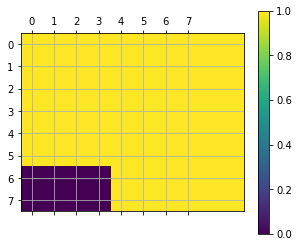

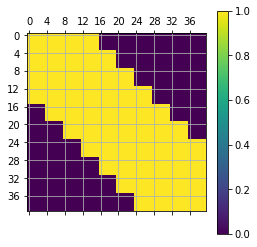

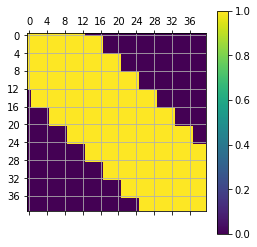

In [35]:
helpers.plot_sparsity_pattern(N_aa[10:18, 0:10], 1)
helpers.plot_sparsity_pattern(N_aa[0:40, 0:40], 4)
helpers.plot_sparsity_pattern(N_aa[-41:-1, -41:-1], 4)

21


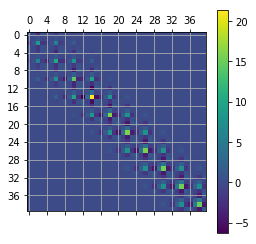

-6.33058617223443


In [27]:
N_aa = Solver.compute_attitude_LHS()
tol = 1
A = N_aa[0:40, 0:40]
B = A #np.zeros(A.shape)
# B[np.where( np.abs(A) > tol)] = 1
plt.matshow(B, fignum=None)
plt.colorbar()
plt.xticks(np.arange(0, B.shape[0], 4))
plt.yticks(np.arange(0, B.shape[0], 4))
plt.grid()
plt.show()
print(N_aa.min())

min_of_A: -0.7058373500743932
min of A:  -0.6204168456923151


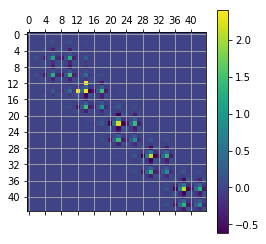

In [80]:
A = N_aa.copy()[0:44,0:44]
my_min = np.amin(A)
print('min_of_A:', my_min)
threshold = A.min()
A[np.where(A==threshold)] = A.max()
print('min of A: ',A.min())
plt.matshow(A, fignum=None)
plt.colorbar()
plt.xticks(np.arange(0, A.shape[0], 4))
plt.yticks(np.arange(0, A.shape[0], 4))
plt.grid()
plt.show()

## _And the righ hand side:_

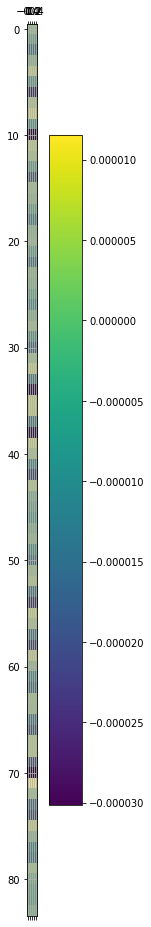

In [39]:
# Plotting h
plt.matshow(h, fignum=None)
plt.colorbar()
plt.grid()
plt.show()

# **Iterating:**

In [40]:
Solver.verbose=False
Solver.reset_iterations()
Solver.iterate(1)

Not resetting everything! Call again the solver instead
***** Iteration: 1 *****
21
0.0035567411335860415
Error after iteration: 1.2617011716741764e-08


In [41]:
Solver.get_attitude(0.005).magnitude

1.000001017761368

In [42]:
Solver.iterate(2)

***** Iteration: 2 *****
21
0.3806628011178194
Error after iteration: 0.0013194517160898859
***** Iteration: 3 *****
21
53.49903829544701
Error after iteration: 1.1070952673177654
